# EPG3345 - Tópicos de Estadística 
# Estudio de Calidad de Vinos

### Profesor: Simón Leiva
### Alumnos:  Madelaine Acosta Donoso - María Olivia Lihn
### 03 de julio - 2018

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from plotly.offline import download_plotlyjs, plot, iplot
from plotly.graph_objs import *
import plotly.plotly as py
from plotly import tools
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from pygam import LogisticGAM
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

C:\Users\molih\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Objetivo

Chile ha llegado a ser mundialmente conocido por la calidad de sus vinos, siendo el primer productor vitivinícola del nuevo mundo y el cuarto a nivel mundial, siendo superado por países europeos tales como Francia, España e Italia. Dada la gran oferta de distintas cepas, viñas y ensamblajes, es cada vez más importante entregar al consumidor un vino de la más alta calidad y una experiencia completa al momento de descorchar una botella. 

En vistas del panorama actual, el objetivo del presente estudio es, utilizando la base de datos "winequality-red" poder determinar las variables químicas que conducen a concluir la calidad de un vino (en este caso, tinto) y, con esta información, poder predecir adecuadamente si un vino será calificado de buena calidad, de manera de direccionar los esfuerzos de la industria en la mejora de la calidad del vino. 

## Información Disponible

Los datos a trabajar corresponden a muestras del vino portugués “Vinho Verde” tinto. Esta base de datos contiene 1599 observaciones y 12 variables (11 variables "objetivas"/químicas y una correspondiente a la calidad en base a juicio experto). Como el interés del estudio era determinar si un vino era bueno o no se incluyó la variable *calidad* creada a partir de la variable *quality*. Las variables medidas en estas muestras fueron:

**Variable**	

* **Acidez fija:**	Conjunto de ácidos naturales procedentes de la uva o formados en la fermentación maloláctica. Esta variable se mide en gramos de ácido tartárico por litro.

* **Acidez volátil:**	Conjunto de ácidos formados durante la fermentación o como consecuencia de alteraciones microbianas. Esta variable también se mide en gramos por litro.

* **Ácido cítrico:**	Es un ácido orgánico tricarboxílico presente en la mayoría de las frutas.

* **Azúcar residual:**	Es el azúcar que queda de la uva sin fermentar.

* **Cloruros:**	Son sales que resultan de la combinación del gas cloro con un metal.

* **Dióxido de azufre libre:**	Es la cantidad de dióxido de azufre que no fue combinado.

* **Dióxido de azufre total:**	Es la cantidad de dióxido de azufre total que queda en el vino.

* **Densidad:**	Se obtiene multiplicando la masa volúmica por el factor 1.0018.

* **pH:**	Es una medida de acidez o alcalinidad de una disolución.

* **Sulfatos:**	Son las sales, ya sea orgánica o mineral, que compone el ácido sulfúrico.

* **Alcohol:**	Grado alcohólico del vino. 

* **Quality:**	(original) Es el puntaje que se le da al vino y va entre 0 y 10.

* **Calidad:**	(artificial) Si el puntaje de calidad (*quality*) de un vino es mayor o igual a 6 se considera que es un vino de buena calidad, esta variable es binaria, donde 1: Bueno y 0: Malo.


In [2]:
wine = pd.read_csv('winequality-red.csv')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
wine.shape

(1599, 12)

## Tratamiento de los Datos

### Creación de Variables

En este caso nos interesa ver si un vino es de buena calidad o mala calidad, para esto se va a considerar que un vino es de buena calidad si tiene una calidad mayor o igual a 6 y de mala calidad si tiene una calidad menor a 6.

In [6]:
wine = wine.assign(Calidad = lambda x: (x.quality>=6 ) * 1 )

### Datos Faltantes

In [7]:
null_percent = wine.isnull().sum() / wine.shape[0] * 100
null_percent

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
Calidad                 0.0
dtype: float64

La base de datos a trabajar no presenta valores faltantes, pero si hay valores que se pueden considerar atípicos, por lo que se decidió aplicar el método de Tukey para eliminar los valores atípicos de las variables continuas.

### Limpieza

In [8]:
def remove_out(df,variable):
    
    for i in variable:
        p_25 = np.percentile(df[i], 25)
        p_75 = np.percentile(df[i], 75)
        df = df[(df[i]< (p_75 + (p_75 - p_25) * 1.5)) & (df[i]> (p_25 - (p_75 - p_25) * 1.5))]
        
    return df

In [9]:
datos = remove_out(wine,['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'])

In [10]:
datos.shape

(1135, 13)

Removimos los datos extremos para todas las variables utilizando el método de Tuckey, eliminando 464 registros.

In [11]:
print('Tabla de Valores')
print(wine['Calidad'].value_counts(sort = False))
print(' ')
print('Tabla de Porcentajes')
print(wine['Calidad'].value_counts(sort = False) / wine.shape[0])

Tabla de Valores
0    744
1    855
Name: Calidad, dtype: int64
 
Tabla de Porcentajes
0    0.465291
1    0.534709
Name: Calidad, dtype: float64


In [12]:
print('Tabla de Valores')
print(datos['Calidad'].value_counts(sort = False))
print(' ')
print('Tabla de Porcentajes')
print(datos['Calidad'].value_counts(sort = False) / datos.shape[0])

Tabla de Valores
0    524
1    611
Name: Calidad, dtype: int64
 
Tabla de Porcentajes
0    0.461674
1    0.538326
Name: Calidad, dtype: float64


Los porcentajes de la variable respuesta se mantienen, por lo que la limpieza no alteró la base de manera significativa en este ámbito. El siguiente esquema muestra lo obtenido. 

![](Esquema.jpg)

## Análisis Descriptivo Univariado

In [13]:
def Resumen(df,variable):
    
    Resumen = df[variable].describe()
    Skew = stats.skew(df[variable])
    Kur = stats.kurtosis(df[variable])
    table_trace2 = pd.DataFrame({ 'Media': [np.round(Resumen['mean'],3)],
                'Std': [np.round(Resumen['std'],3)],
                'Mínimo': [np.round(Resumen['min'],3)],
                'Q1': [np.round(Resumen['25%'],3)],
                'Mediana':[np.round(Resumen['50%'],3)],
                'Q3': [np.round(Resumen['75%'],3)],
                'Máximo': [np.round(Resumen['max'],3)],
                'Skewness': [np.round(Skew,3)],
                'Kurtosis': [np.round(Kur,3)]},
                 index=['Valor'],
                 columns=['Media','Std','Mínimo','Q1','Mediana','Q3',
                         'Máximo','Skewness','Kurtosis']) 
    
    return table_trace2 

In [14]:
def Graficos(df,variable, color1, color2):
    plt.style.use('ggplot')
    plt.subplot(121)
    df[variable].plot(x = variable , kind = 'hist', color = color1 )
    plt.subplot(122)
    df[variable].plot(x = variable , kind = 'box', color = color2 )
    return 

**Acidez fija**

In [15]:
Resumen(datos,'fixed acidity')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,8.147,1.444,5.1,7.1,7.8,9.0,12.3,0.773,0.116


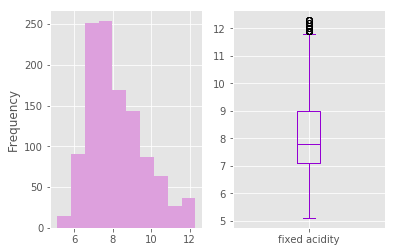

In [16]:
Graficos(datos,'fixed acidity','#DDA0DD' ,'#9400D3')

Como se puede apreciar en la tabla y en los gráficos se tiene que la acidez fija media fue de 8.147 con una desviación de 1.444, además se tiene que el mínimo fue de 5.1 y el máximo de 12.3.

Por otro lado se tiene que el 75% de los vino tiene una acidez fija menor o igual a 9.

Ahora analizando la forma de la forma de la distribución se tiene que la distribución no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a -0.773 lo que nos indica una asimetría negativa, además se tiene que el coeficientes de curtosis es de 0.116 lo que indica que la distribución es más apuntada y con colas menos pesadas que una normal.


**Acidez volátil**

In [17]:
Resumen(datos,'volatile acidity')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,0.522,0.165,0.12,0.39,0.52,0.63,1.005,0.273,-0.243


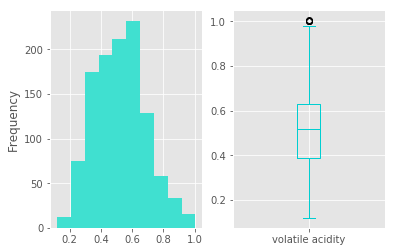

In [18]:
Graficos(datos,'volatile acidity', '#40E0D0', '#00CED1')

Se tiene que la acidez volátil media fue de 0.522 con una desviación de 0.165, además se tiene que el mínimo fue de 0.12 y el máximo de 1.005.

Por otro lado se tiene que el 75% de los vino tiene una acidez fija menor o igual a 0.63.

Ahora analizando la forma de la forma de la distribución se tiene que la distribución no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a 0.273 lo que nos indica una asimetría positiva, además se tiene que el coeficientes de curtosis es de -0.243 lo que indica que la distribución es levemente menos apuntada y con colas algo más pesadas que una normal.


**Ácido cítrico**

In [19]:
Resumen(datos, 'citric acid')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,0.246,0.18,0.0,0.08,0.24,0.39,0.73,0.325,-0.908


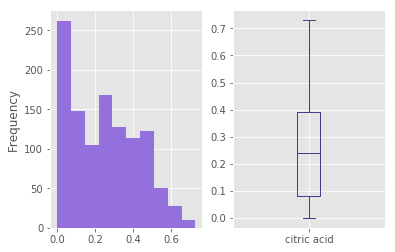

In [20]:
Graficos(datos, 'citric acid', '#9370DB', '#483D8B')

Se tiene que la cantidad de ácido cítrico medio fue de 0.246 con una desviación de 0.18, además se tiene que la cantidad mínima fue de 0 y la cantidad máxima fue de 0.73.

Por otro lado se tiene que el 75% de los vino tiene una acidez fija menor o igual a 0.39.

Ahora analizando la forma de la forma de la distribución se tiene que la distribución no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a 0.325 lo que nos indica una asimetría positiva, además se tiene que el coeficientes de curtosis es de -0.908 lo que indica que la distribución es menos apuntada y con colas más gruesas que la normal.


**Azúcar residual**

In [21]:
Resumen(datos,'residual sugar')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,2.181,0.439,1.2,1.9,2.1,2.4,3.6,0.638,0.475


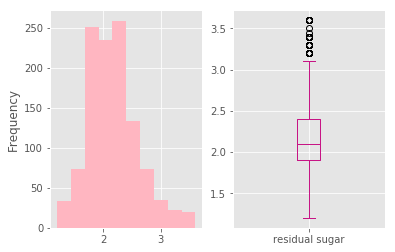

In [22]:
Graficos(datos, 'residual sugar', '#FFB6C1','#C71585')

De la tabla se tiene que la cantidad de azúcar residual media fue de 2.181 con una desviación de 0.439, además se tiene que la cantidad mínima fue de 1.2 y la cantidad máxima fue de 3.6.

Además se tiene que el 75% de los vino tiene una acidez fija menor o igual a 2.4.

Si vemos la forma de la distribución se tiene que la distribución no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a -0.638 lo que nos indica una asimetría negativa, además se tiene que el coeficientes de curtosis es de 0.475 lo que indica que la distribución es más apuntada y con colas menos gruesas que la normal.


**Cloruros**

In [23]:
Resumen(datos,'chlorides')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,0.078,0.014,0.042,0.069,0.078,0.087,0.116,0.174,0.062


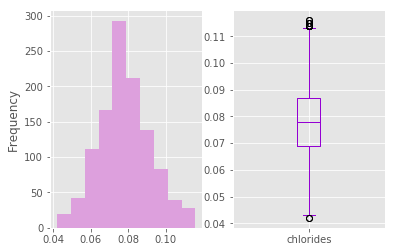

In [24]:
Graficos(datos,'chlorides','#DDA0DD' ,'#9400D3')

Al analizar la tabla de los estadísticos se obtiene que la cantidad de cloruro  medio en el vino es de 0.078 con una desviación de 0.014, además se tiene que la cantidad mínima fue de 0.042 y la cantidad máxima fue de 0.116.

Además se tiene que el 75% de los vino tiene una acidez fija menor o igual a 0.087.

Si vemos la forma de la distribución se tiene que la distribución es bastante simétrica, si comparamos su media con su mediana se tiene que son el mismo valor, además se tiene que el coeficiente de asimetría es pequeño.


**Dióxido de azufre libre**

In [25]:
Resumen(datos,'free sulfur dioxide')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,14.789,8.588,1.0,8.0,13.0,20.0,40.0,0.794,-0.061


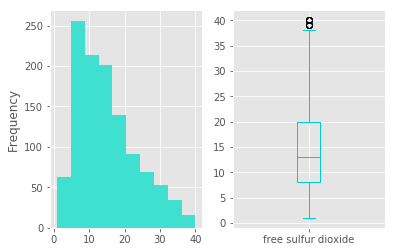

In [26]:
Graficos(datos,'free sulfur dioxide', '#40E0D0', '#00CED1')

Como se puede apreciar en la tabla y en los gráficos se tiene que la cantidad de dióxido de carbono libre medio fue de 14.789 con una desviación de 8.588, además se tiene que la cantidad mínima fue de 1 y la máxima de 40.

Por otro lado se tiene que el 75% de los vino tiene una cantidad de dióxido de azufre libre menor o igual a 20.

Ahora analizando la forma de la distribución se tiene que la distribución no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a 0.794 lo que nos indica una asimetría positiva, además se tiene que el coeficiente de curtosis es de -0.061 lo que indica que la distribución es menos apuntada y con colas más gruesas que la normal.


**Dióxido de azufre total**

In [27]:
Resumen(datos,'total sulfur dioxide')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,40.946,24.626,6.0,22.0,35.0,54.0,113.0,0.917,0.164


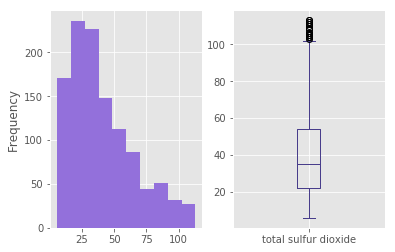

In [28]:
Graficos(datos, 'total sulfur dioxide', '#9370DB', '#483D8B')

Se puede apreciar que la cantidad de dióxido de azufre total medio fue de 40.946 con una desviación de 24.626, además se tiene que la cantidad mínima fue de 6 y la máxima de 113.

El 75% de los vino tiene una acidez fija menor o igual a 54.

Analizando la forma de la distribución se tiene que la distribución claramente no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a 0.917 lo que nos indica una asimetría positiva, además se tiene que el coeficientes de curtosis es de 0.164 lo que indica que la distribución es más apuntada y con colas menos gruesas que la normal.

El comportamiento las distribuciones de dióxido de azufre libre y dióxido de azufre total es muy parecida, solo cambia el rango de los valores que toman y esto se debe a que el dióxido de azufre libre es un subconjunto del dióxido de azufre total.


**Densidad**

In [29]:
Resumen(datos,'density')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,0.997,0.002,0.993,0.996,0.997,0.998,1.0,0.091,-0.144


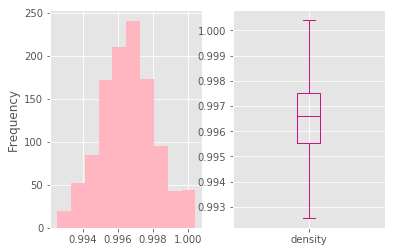

In [30]:
Graficos(datos, 'density', '#FFB6C1','#C71585')

Se puede apreciar que la densidad media fue de 0.997 con una desviación de 0.002, además se tiene que la densidad mínima fue de 0.993 y la máxima de 1.

Por otro lado se tiene que el 75% de los vino tiene una densidad menor o igual a 0.998.

Ahora analizando la forma de la distribución se tiene que la distribución es bastante simétrica y el coeficiente asimetría es pequeño, además se tiene que el coeficientes de curtosis es de -0.144 lo que indica que la distribución es menos apuntada y con colas más gruesas que la normal. Si vemos el boxplot se aprecia que no hay valores atípicos.


**pH** 

In [31]:
Resumen(datos,'pH')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,3.325,0.13,2.98,3.23,3.33,3.4,3.68,0.094,-0.3


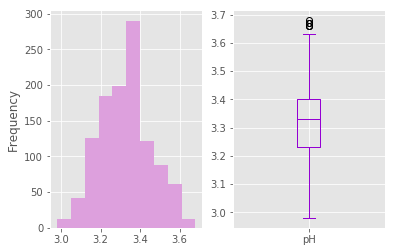

In [32]:
Graficos(datos,'pH','#DDA0DD' ,'#9400D3')

Como se puede apreciar en la tabla se tiene que el pH medio fue de 3.325 con una desviación de 0.13, además se tiene que el pH mínimo fue de 2.98 y el máximo de 3.68, con esto valores se tiene que el pH en los vino es ácido.

Por otro lado se tiene que el 75% de los vino tiene una acidez fija menor o igual a 3.68.

Si vemos la forma de la distribución se tiene que la distribución es bastante simétrica ya que la media es muy parecida a la mediana, y el coeficiente de asimetría es pequeño, además se tiene que el coeficientes de curtosis es de -0.3 lo que indica que la distribución es menos apuntada y con colas más gruesas que la normal.


**Sulfatos**

In [33]:
Resumen(datos,'sulphates')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,0.628,0.112,0.33,0.55,0.61,0.7,0.94,0.552,-0.114


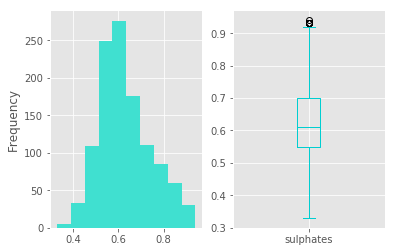

In [34]:
Graficos(datos,'sulphates', '#40E0D0', '#00CED1')

Como se puede apreciar en la tabla se tiene que la cantidad de sulfato en el vino es en promedio 0.628  con una desviación de 0.112, además se tiene que la cantidad mínima de sulfato fue de 0.33 y la máxima de 0.94.

Por otro lado se tiene que el 75% de los vino tiene una acidez fija menor o igual a 0.7.

Ahora analizando la forma de la distribución se tiene que la distribución se ve un poco simétrica, la media y la mediana son cercanas, sin embargo el valor del coeficiente de asimetría que corresponde a 0.552 lo que nos indica una asimetría positiva y este valor igual es grande, además se tiene que el coeficientes de curtosis es de -0.114 lo que indica que la distribución es menos apuntada y con colas más gruesas que la normal.


**Alcohol**

In [35]:
Resumen(datos,'alcohol')

,Media,Std,Mínimo,Q1,Mediana,Q3,Máximo,Skewness,Kurtosis
Valor,10.353,0.954,8.7,9.5,10.1,11.0,13.0,0.731,-0.326


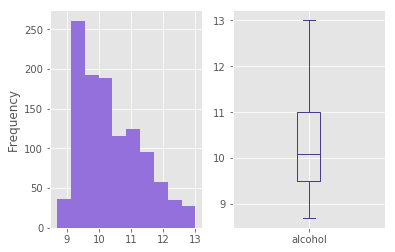

In [36]:
Graficos(datos, 'alcohol', '#9370DB', '#483D8B')

Se tiene que el alcohol  medio en el vino es de 10.353 con una desviación de 0.954, además se tiene que el alcohol mínimo es de 8.7 y el máximo de 13.

Por otro lado se tiene que el 75% de los vino tiene una cantidad de alcohol menor o igual a 11.

Ahora analizando la forma de la distribución se tiene que la distribución no es simétrica lo cual se confirma con el valor del coeficiente de asimetría que corresponde a 0.731 lo que nos indica una asimetría positiva, además se tiene que el coeficientes de curtosis es de -0.326 lo que indica que la distribución es menos apuntada y con colas más gruesas que la normal. Del boxplot se tiene que no hay valores atípicos.


**Quality**

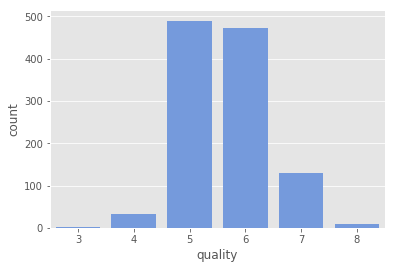

In [37]:
sns.countplot(x='quality', data=datos, color = '#6495ED')

In [38]:
print('Tabla de Valores')
print(datos['quality'].value_counts(sort = False))
print(' ')
print('Tabla de Porcentajes')
print(datos['quality'].value_counts(sort = False) / datos.shape[0])

Tabla de Valores
3      2
4     32
5    490
6    472
7    130
8      9
Name: quality, dtype: int64
 
Tabla de Porcentajes
3    0.001762
4    0.028194
5    0.431718
6    0.415859
7    0.114537
8    0.007930
Name: quality, dtype: float64


Se tiene que las calidades de los vinos en la muestra van de 3 a 8, donde la mayor cantidad de vinos tiene una calidad de 5 o 6.

**Calidad**

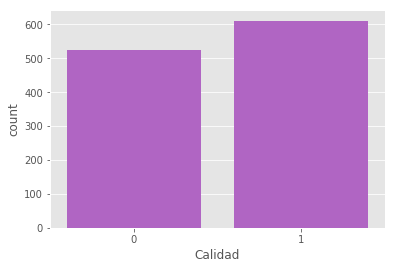

In [39]:
sns.countplot(x='Calidad', data=datos, color = '#BA55D3')

In [40]:
print('Tabla de Valores')
print(datos['Calidad'].value_counts(sort = False))
print(' ')
print('Tabla de Porcentajes')
print(datos['Calidad'].value_counts(sort = False) / datos.shape[0])

Tabla de Valores
0    524
1    611
Name: Calidad, dtype: int64
 
Tabla de Porcentajes
0    0.461674
1    0.538326
Name: Calidad, dtype: float64


## Análisis Descriptivo Multivariado

In [41]:
wine[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']].corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


In [42]:
Correlaciones = datos[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']].corr()

La siguiente imagen corresponde a un heatmap, el cual nos muestra la relación que hay entre las variables continuas, y a partir de los colores se puede ver cuáles son las variables que están más relacionadas

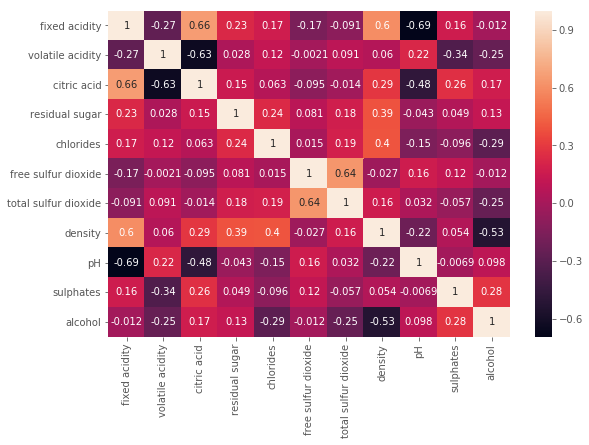

In [43]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Correlaciones, annot=True)

Como se puede apreciar se tiene que las variables más correlacionadas son:

* **fixed acidity - citric acid** 
* **fixed acidity - density**
* **fixed acidity - pH**
* **volatile acidity - citric acid**
* **citric acid - pH**
* **free sulfur dioxide - total sulfur dioxide**

## Ajuste de Modelos

En esta parte se ajustarán y validarán distintos tipos de modelos para obtener cuales son las variables que más influyen en que un vino sea de buena calidad. Además se verá cual es el mejor modelo para predecir si un vino es bueno o malo.

### Separación Bases de Entrenamiento y Validación

Para poder ajustar y validar los modelos se separó la base en 80-20, es decir, 80% de los datos son para la construcción de los modelos y el 20% restante para la validación. 

In [44]:
def particion(df, ptrain=0.7):
    ptest=1-ptrain
    particion = train_test_split(df.index, test_size = ptest)
    train = df.loc[particion[0]]
    test = df.loc[particion[1]]
    
    return train, test

In [45]:
train, test = particion(datos)

Exportamos las bases al momento de realizar la división de manera que no cambien los análisis realizados: 

In [46]:
#train.to_csv('train.csv', decimal = ',', sep=' ', encoding='utf-8')
#test.to_csv('test.csv', decimal = ',', sep=' ', encoding='utf-8')

In [47]:
wine_train = pd.read_table('train.csv', 
                          header = 0,
                          sep = ' ',
                          decimal = ',',
                          index_col = 0)
wine_test = pd.read_table('test.csv', 
                          header = 0,
                          sep = ' ',
                          decimal = ',',
                          index_col = 0)

In [48]:
wine_train.rename(columns = {'fixed acidity' : 'fixed_acidity',
                                 'volatile acidity' : 'volatile_acidity',
                                 'citric acid' : 'citric_acid',
                                 'residual sugar' : 'residual_sugar',
                                 'free sulfur dioxide' : 'free_sulfur_dioxide',
                                'total sulfur dioxide' : 'total_sulfur_dioxide'}, inplace = True)

In [49]:
wine_test.rename(columns = {'fixed acidity' : 'fixed_acidity',
                                 'volatile acidity' : 'volatile_acidity',
                                 'citric acid' : 'citric_acid',
                                 'residual sugar' : 'residual_sugar',
                                 'free sulfur dioxide' : 'free_sulfur_dioxide',
                                'total sulfur dioxide' : 'total_sulfur_dioxide'}, inplace = True)

In [50]:
wine_train.shape

(794, 13)

In [51]:
wine_train['Calidad'].value_counts(sort = False) /wine_train.shape[0]

0    0.449622
1    0.550378
Name: Calidad, dtype: float64

In [52]:
wine_train['quality'].value_counts(sort = False) /wine_train.shape[0]

3    0.002519
4    0.030227
5    0.416877
6    0.423174
7    0.117128
8    0.010076
Name: quality, dtype: float64

In [53]:
wine_test.shape

(341, 13)

In [54]:
wine_test['Calidad'].value_counts(sort = False) /wine_test.shape[0]

0    0.489736
1    0.510264
Name: Calidad, dtype: float64

In [55]:
wine_test['quality'].value_counts(sort = False) /wine_test.shape[0]

4    0.023460
5    0.466276
6    0.398827
7    0.108504
8    0.002933
Name: quality, dtype: float64

De la separación se obtuvo lo siguiente:
    ![](Esquema1.jpg)

Como se puede apreciar en ambas muestras se logra conservar aproximadamente las proporciones de vinos de buena y mala calidad de la base completa.

## Modelos

#### Funciones a utilizar

In [56]:
modelo_completo = """Calidad ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +
                            chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol """
modelo_completo_si = """Calidad ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +
                            chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol-1 """

In [57]:
def Metricas_Modelo(real, predicho, corte):
    
    roc = metrics.roc_curve(real, predicho)
    umbral = corte
    preds_val = (predicho >= umbral) * 1
    M = metrics.confusion_matrix(real, preds_val)
    tn, fp, fn, tp = M.ravel()
    Accu = (tn+tp)/(tn+fn+tp+fp)
    Pre = tp/(tp+fp)
    Recall = tp/(tp+fn)
    AUC = metrics.auc(roc[0], roc[1])
    Brier = (1/(len(real)))*np.sum((predicho-real).transpose()*(predicho-real))
    met = pd.DataFrame({'Accuracy': [Accu], 'Precision': [Pre],
                        'Recall': [Recall], 'AUC': [AUC], 'Punto de Corte': [corte], 
                        'Brier':Brier, '%fp':fp/(tn+fn+tp+fp)*100,'%fn':fn/(tn+fn+tp+fp)*100}
                       , index= ['Valor'],
                      columns = ['Punto de Corte', 'Accuracy','Precision','Recall','AUC','Brier','%fp','%fn'])
    
    return met

In [58]:
def Grafico_KS(preds,y):
    score = preds
    pos = pd.get_dummies(y).as_matrix()
    neg = pos[:,0]
    pos = pos[:,1]
    npos = np.sum(pos)
    nneg = np.sum(neg)
    index = np.argsort(score)
    index = index[::-1]
    index_neg = np.argsort(score)
    index_neg = index_neg[::-1]
    sort_pos = pos[index]
    sort_neg = neg[index_neg]
    cpos = np.cumsum(sort_pos)
    cneg = np.cumsum(sort_neg)
    n = y.shape[0]
    nneg = n-npos
    recall = cpos/npos
    recall_n = cneg/nneg
    size = np.arange(start=1,stop=n+1,step=1)
    size = size / n
    opt = npos / n
    plt.style.use('ggplot')
    plt.title('Curva KS    (KS = ' +str(np.round(np.max(recall-recall_n),4))+')' )
    plt.xlabel('Target size (Rate of Positive Predictions)')
    plt.ylabel('Recall (True Positive Rate)')
    plt.xlim(0,1)
    plt.ylim(0,1.05)
    plt.plot(size,recall_n, color='blue', label = "Negativa")
    graf= plt.plot(size,recall,color ='red', label = "Positiva")
    plt.legend(loc="lower right")
    
    return graf

In [59]:
def Grafico_Ganancia(preds,y):
    score = preds
    pos = pd.get_dummies(y).as_matrix()
    pos = pos[:,1]
    npos = np.sum(pos)
    index = np.argsort(score)
    index = index[::-1]
    sort_pos = pos[index]
    cpos = np.cumsum(sort_pos)
    recall = cpos/npos
    n = y.shape[0]
    size = np.arange(start=1,stop=n+1,step=1)
    size = size / n
    opt = npos / n
    plt.style.use('ggplot')
    plt.title('Curva de Ganancia')
    plt.xlabel('Target size (Rate of Positive Predictions)')
    plt.ylabel('Recall (True Positive Rate)')
    plt.xlim(0,1)
    plt.ylim(0,1.05)
    plt.plot(size,size,color='blue')
    plt.plot(size,recall,color ='red')
    graf = plt.plot([0, opt, 1], [0, 1, 1], color ='green')

    return graf

In [60]:
def Grafico_Distribuciones(df):
    plt.style.use('ggplot')
    n = df.query('y == 0')['Preds']
    p = df.query('y == 1')['Preds']
    plt.hist([n,p],color = ['red','blue'],label=["Negativos","Positivos"])

    plt.legend(loc="lower right")
    plt.title('Gráfico de Distribuciones')

    plt.show()

In [61]:
def Grafico_ROC(roc, modelo):
    plt.plot(roc[0], roc[1], label = modelo, color = 'blue')
    plt.plot([0,1], [0,1], 'r--', color = 'red')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC ' + modelo + '       (AUC = ' +str(np.round(metrics.auc(roc[0], roc[1]), 4))+')' )
    plt.legend(loc="lower right")
    plt.show()

### Regresión Logística

**Modelo Completo**

En este modelo se utilizaron todas las variables para poder ver cuáles son las más importantes, para este modelo se obtuvo el siguiente resultado:

In [62]:
fit_0_Logit = smf.logit(formula = modelo_completo, data = wine_train)
results_Logit_0 = fit_0_Logit.fit()

Optimization terminated successfully.
         Current function value: 0.516858
         Iterations 7


In [63]:
results_Logit_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Calidad   No. Observations:                  794
Model:                          Logit   Df Residuals:                      782
Method:                           MLE   Df Model:                           11
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:                  0.2488
Time:                        15:27:59   Log-Likelihood:                -410.39
converged:                       True   LL-Null:                       -546.32
                                        LLR p-value:                 7.231e-52
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               37.3008    143.499      0.260      0.795    -243.951     318.553
fixed_acidity            0.1479      0.156      0.946      0.344      -0.158       0.454
volatile_acidity        -3.3473      0.786     -4.258      0.000      -4.888      -1.807
citric_acid             -2.4047      0.858     -2.802      0.005      -4.087      -0.722
residual_sugar           0.1199      0.256      0.467      0.640      -0.383       0.622
chlorides               -7.5383      7.172     -1.051      0.293     -21.596       6.520
free_sulfur_dioxide      0.0044      0.014      0.318      0.751      -0.023       0.032
total_sulfur_dioxide    -0.0078      0.005     -1.477      0.140      -0.018       0.003
density                -43.1695    146.167     -0.295      0.768    -329.651     243.312
pH                      -1.6148      1.162     -1.390      0.165      -3.892       0.663
sulphates                5.7496      0.941      6.112      0.000       3.906       7.593
alcohol                  0.9174      0.184      4.996      0.000       0.557       1.277
========================================================================================
"""

Al ajustar el modelo completo con la regresión logística se tiene que hay siete variables en la cuales el intervalos de confianza contiene el 0 y el valor p es mayor a 0.05  por lo que no serían significativas para el modelo. Para ver que variables son realmente significativas se utilizara la selección por Método Lasso.

In [64]:
fit_selec_Logit = smf.logit(formula = modelo_completo_si, data = wine_train)
result_selec_Logit = fit_selec_Logit.fit_regularized(method = 'l1', alpha = 1) 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5366965981525935
            Iterations: 89
            Function evaluations: 94
            Gradient evaluations: 89


In [65]:
result_selec_Logit.params

fixed_acidity          -0.052790
volatile_acidity       -2.586325
citric_acid            -1.111462
residual_sugar          0.013675
chlorides               0.000000
free_sulfur_dioxide     0.013781
total_sulfur_dioxide   -0.012495
density                 0.000000
pH                     -2.884978
sulphates               4.750974
alcohol                 0.890453
dtype: float64

Como podemos apreciar las variables que son significativas en este caso son: 

![](img1.jpg)

* **acidez fija**
* **acidez volátil**
* **ácido cítrico**
* **azúcar residual**
* **dióxido de sulfuro libre**
* **dióxido de azufre total**
* **pH**
* **sulfatos**
* **alcohol**

Sin embargo, se tiene que los betas de algunas variables se pueden considerar muy cercanos a 0, por lo que si quitamos esas variables nos quedamos con las siguientes variables:

![](img2.jpg)

* **acidez volátil**
* **ácido cítrico**
* **pH**
* **sulfatos**
* **alcohol**

Con esto generamos dos modelos nuevos.

**Modelo Grupo 1 de Variables**

In [66]:
modelo_final_Logit_1= """Calidad ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar 
                             + free_sulfur_dioxide + total_sulfur_dioxide + pH + sulphates + alcohol """
modelo_final_Logit_2= """Calidad ~ volatile_acidity + citric_acid + pH + sulphates + alcohol """

In [67]:
fit_1_Logit = smf.logit(formula = modelo_final_Logit_1, data = wine_train)
results_Logit_1 = fit_1_Logit.fit()

Optimization terminated successfully.
         Current function value: 0.517708
         Iterations 6


In [68]:
results_Logit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Calidad   No. Observations:                  794
Model:                          Logit   Df Residuals:                      784
Method:                           MLE   Df Model:                            9
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:                  0.2476
Time:                        15:27:59   Log-Likelihood:                -411.06
converged:                       True   LL-Null:                       -546.32
                                        LLR p-value:                 4.586e-53
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.7583      3.753     -1.534      0.125     -13.114       1.597
fixed_acidity            0.1035      0.105      0.987      0.324      -0.102       0.309
volatile_acidity        -3.4098      0.777     -4.389      0.000      -4.933      -1.887
citric_acid             -2.3971      0.852     -2.812      0.005      -4.068      -0.726
residual_sugar           0.0247      0.206      0.120      0.905      -0.380       0.429
free_sulfur_dioxide      0.0059      0.014      0.431      0.667      -0.021       0.033
total_sulfur_dioxide    -0.0087      0.005     -1.668      0.095      -0.019       0.002
pH                      -1.7741      0.975     -1.820      0.069      -3.685       0.136
sulphates                5.6371      0.911      6.190      0.000       3.852       7.422
alcohol                  0.9807      0.117      8.353      0.000       0.751       1.211
========================================================================================
"""

Se tiene que hay seis variables en la cuales el intervalos de confianza contiene el 0 y el valor p es mayor a 0.05  por lo que no serían significativas para el modelo.

**Modelo Grupo 2 de Variables**

In [69]:
fit_2_Logit = smf.logit(formula = modelo_final_Logit_2, data = wine_train)
results_Logit_2 = fit_2_Logit.fit()

Optimization terminated successfully.
         Current function value: 0.521436
         Iterations 6


In [70]:
results_Logit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Calidad   No. Observations:                  794
Model:                          Logit   Df Residuals:                      788
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:                  0.2422
Time:                        15:27:59   Log-Likelihood:                -414.02
converged:                       True   LL-Null:                       -546.32
                                        LLR p-value:                 4.036e-55
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.7379      2.726     -1.371      0.170      -9.080       1.604
volatile_acidity    -3.3452      0.727     -4.600      0.000      -4.771      -1.920
citric_acid         -2.1511      0.685     -3.143      0.002      -3.493      -0.810
pH                  -2.4486      0.778     -3.148      0.002      -3.973      -0.924
sulphates            5.7362      0.898      6.388      0.000       3.976       7.496
alcohol              1.0487      0.111      9.435      0.000       0.831       1.267
====================================================================================
"""

De la tabla anterior podemos notar que solo hay una variable que contiene al cero en su intervalo de confianza y tiene un valor p mayor a 0.05, sin embargo, como el valor p no es tan grande esta variable se dejara en el modelo.

### Random Forest

**Modelo Completo**

Se ajustó un modelo de Random Foresto con los datos completos y 100 árboles.

In [71]:
ytr1, Xtr1 = patsy.dmatrices("""Calidad ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +
                            chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol-1""",
                           data = wine_train)

yte1, Xte1 = patsy.dmatrices("""Calidad ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +
                            chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol-1""",
                           data = wine_test)

In [72]:
fit_rf_1 = RandomForestClassifier(n_estimators = 100)
fit_rf_1 = fit_rf_1.fit(Xtr1, np.ravel(ytr1))
preds_rf_1 = fit_rf_1.predict_proba(Xte1)

In [73]:
fit_rf_1.feature_importances_

array([0.0708299 , 0.10603867, 0.06964163, 0.05600601, 0.08005273,
       0.05717355, 0.08984226, 0.10020682, 0.06446259, 0.13290685,
       0.17283898])

Con este modelo se obtuvo lo siguiente:

|Variable |	Importancia |
| ------- | ----------- |
|Acidez fija |0.07047461 |
|Acidez volátil | 0.10603867 |
|Ácido cítrico | 0.06964163 |
|Azúcar Residual|	0.05600601|
|Cloruros|	0.08005273|
|Dióxido de azufre libre|	0.05717355|
|Dióxido de azufre total |0.08984226|
|Densidad|	0.10020682|
|pH	|0.06446259|
|Sulfatos	| 0.13290685|
|Alcohol|	0.17283898|

Como podemos apreciar las variables con mayor importancia (sobre 0.08) son:

* **Alcohol**
* **Sulfatos** 
* **Acidez volátil**
* **Densidad**
* **Dióxido de azufre total**
* **Cloruro**


**Modelo Variables Seleccionadas**

In [74]:
ytr11, Xtr11 = patsy.dmatrices("""Calidad ~ density + volatile_acidity + chlorides +  total_sulfur_dioxide +sulphates + alcohol-1""",
                           data = wine_train)

yte11, Xte11 = patsy.dmatrices("""Calidad ~ density + volatile_acidity + chlorides +  total_sulfur_dioxide +sulphates + alcohol-1""",
                           data = wine_test)

In [75]:
fit_rf_2 = RandomForestClassifier(n_estimators = 100)
fit_rf_2 = fit_rf_2.fit(Xtr11, np.ravel(ytr11))
preds_rf_2 = fit_rf_2.predict_proba(Xte11)

In [76]:
fit_rf_2.feature_importances_

array([0.15363324, 0.17599588, 0.13038004, 0.13873283, 0.17563802,
       0.22561999])

### Logistic GAM

**Modelo Completo**

In [77]:
fit_gam_1 = LogisticGAM().fit(Xtr1, ytr1)
fit_gam_1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    110.5042
Link Function:                        LogitLink Log Likelihood:                                  -306.5721
Number of Samples:                          794 AIC:                                              834.1526
                                                AICc:                                             870.9678
                                                UBRE:                                               3.1619
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4388
Feature Function   Data Type      Num

Como se puede apreciar en el resumen anterior hay 4 variables que serían significativas, la 2, 5, 10 y 11, es decir:

* **acidez volátil**
* **cloruros**
* **sulfatos**
* **alcohol**

**Modelo Variables Seleccionadas**

In [78]:
ytr2, Xtr2 = patsy.dmatrices("""Calidad ~  volatile_acidity + chlorides + sulphates + alcohol-1""",
                           data = wine_train)

yte2, Xte2 = patsy.dmatrices("""Calidad ~ volatile_acidity + chlorides + sulphates + alcohol-1""",
                           data = wine_test)

In [79]:
fit_gam_2 = LogisticGAM().fit(Xtr2, ytr2)
fit_gam_2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     42.5433
Link Function:                        LogitLink Log Likelihood:                                  -370.9667
Number of Samples:                          794 AIC:                                                827.02
                                                AICc:                                              832.196
                                                UBRE:                                               3.0845
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.321
Feature Function   Data Type      Num

**Variables que influyen en la buena calidad del vino**

A continuación se muestra una tabla con las variables seleccionadas por los modelos y por cuántos modelos fueron seleccionadas.

|Variables|	Seleccionada|
|---------|-------------|
|Acidez Volátil|	3 |
|Ácido Cítrico|	1|
|pH	|1|
|Sulfatos|	3|
|Alcohol|	3|
|Densidad|	1|
|Cloruro|	2|
|Dióxido de azufre total|1|


Tenemos que hay tres variables que fueron seleccionadas por los tres modelos, estas variables son los sulfatos, el alcohol y la acidez volátil, dos modelos seleccionaron el cloruro, estas variables son muy influyentes en la buena calidad del vino, mientras que el ácido cítrico, el pH, la densidad y el dióxido de azufre total son influyentes dependiendo el modelo que se elija.

Ahora que ya tenemos las variables más influyentes en la buena calidad del vino se ajusta un nuevo modelo con esas cuatro variables y este modelo será un modelo de Naive Bayes.


### Naive Bayes

In [80]:
ytr3, Xtr3 = patsy.dmatrices("""Calidad ~  volatile_acidity +chlorides+ sulphates + alcohol-1""",
                           data = wine_train)

yte3, Xte3 = patsy.dmatrices("""Calidad ~ volatile_acidity + chlorides+sulphates + alcohol-1""",
                           data = wine_test)

In [81]:
fit_nb_1 = GaussianNB()
fit_nb_1 = fit_nb_1.fit(Xtr3,np.ravel(ytr3))
preds_nb_1 = fit_nb_1.predict_proba(Xte3)

## Validación de los modelos

### Regresión Logística

**Modelo Completo**

**Métricas**

In [82]:
preds_Logit_mod0 = fit_0_Logit.fit().predict(wine_test)
Metricas_Modelo(wine_test['Calidad'], preds_Logit_mod0,  0.5)

Optimization terminated successfully.
         Current function value: 0.516858
         Iterations 7


C:\Users\molih\Anaconda3\lib\site-packages\statsmodels\base\model.py:775: DeprecationWarning:

The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)



,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.747801,0.771605,0.718391,0.817641,0.174538,10.85044,14.369501


**Gráfico KS**

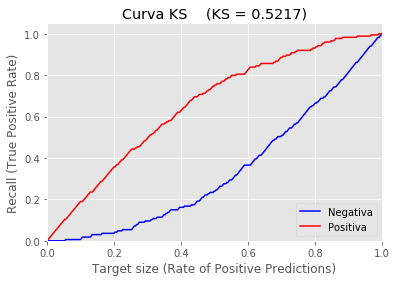

In [83]:
Grafico_KS(preds_Logit_mod0 ,wine_test['Calidad'])

**Gráfico de Ganancia**

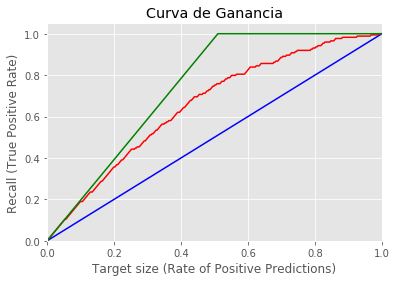

In [84]:
Grafico_Ganancia(preds_Logit_mod0 ,wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



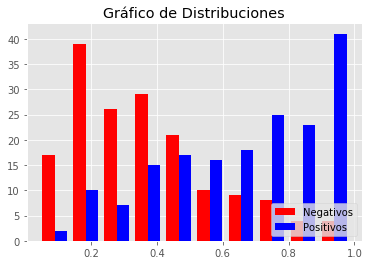

In [85]:
datoslogit0 = pd.DataFrame({'Preds':preds_Logit_mod0 ,'y':wine_test['Calidad']})
Grafico_Distribuciones(datoslogit0)

**Curva ROC**

In [86]:
roc_logit_0 = metrics.roc_curve(wine_test['Calidad'], preds_Logit_mod0)

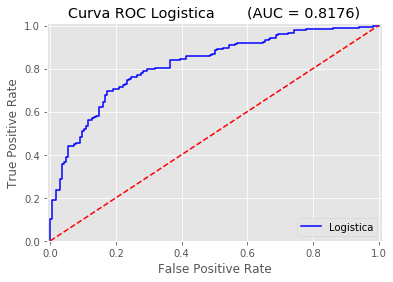

In [87]:
Grafico_ROC(roc_logit_0, 'Logistica')

**Modelo Grupo 1 de Variables**

In [88]:
preds_test_Logit_1 = results_Logit_1.predict(wine_test)
Metricas_Modelo(wine_test['Calidad'], preds_test_Logit_1, 0.5)

C:\Users\molih\Anaconda3\lib\site-packages\statsmodels\base\model.py:775: DeprecationWarning:

The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)



,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.747801,0.761905,0.735632,0.818054,0.17458,11.730205,13.489736


**Gráfico KS**

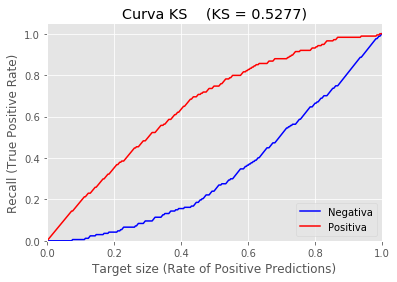

In [89]:
Grafico_KS(preds_test_Logit_1 ,wine_test['Calidad'])

**Gráfico de Ganancia**

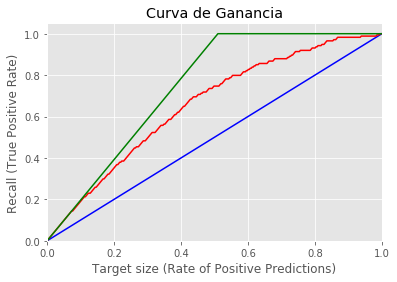

In [90]:
Grafico_Ganancia(preds_test_Logit_1 ,wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



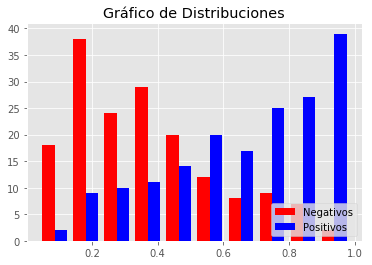

In [91]:
datoslogit1 = pd.DataFrame({'Preds':preds_test_Logit_1,'y':wine_test['Calidad']})
Grafico_Distribuciones(datoslogit1)

**Curva ROC**

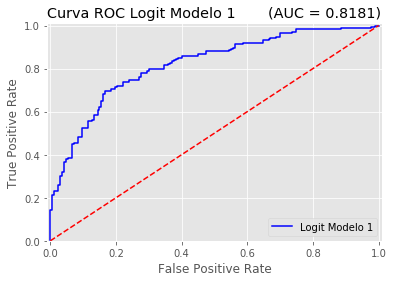

In [92]:
roc_Logit_1 = metrics.roc_curve(wine_test['Calidad'], preds_test_Logit_1)
Grafico_ROC(roc_Logit_1, 'Logit Modelo 1')

**Modelo Grupo 2 de Variables**

**Métricas**

In [93]:
preds_test_Logit_2 = results_Logit_2.predict(wine_test)
Metricas_Modelo(wine_test['Calidad'], preds_test_Logit_2, 0.5)

C:\Users\molih\Anaconda3\lib\site-packages\statsmodels\base\model.py:775: DeprecationWarning:

The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)



,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.756598,0.775758,0.735632,0.817331,0.174214,10.85044,13.489736


**Gráfico KS**

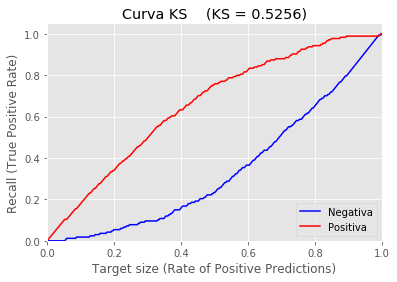

In [94]:
Grafico_KS(preds_test_Logit_2 ,wine_test['Calidad'])

**Gráfico de Ganancia**

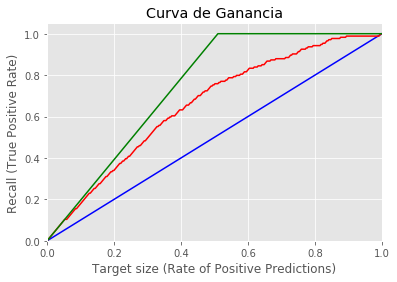

In [95]:
Grafico_Ganancia(preds_test_Logit_2 ,wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



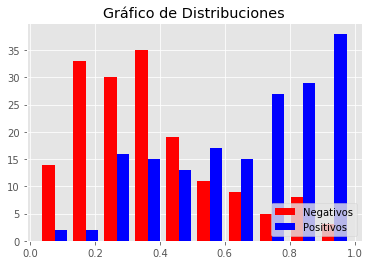

In [96]:
datoslogit2 = pd.DataFrame({'Preds':preds_test_Logit_2,'y':wine_test['Calidad']})
Grafico_Distribuciones(datoslogit2)

**Curva ROC**

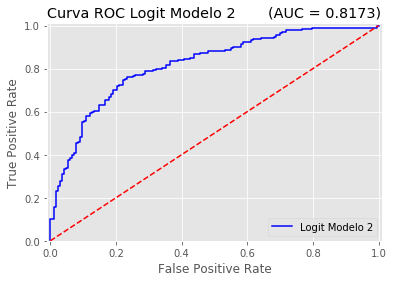

In [97]:
roc_Logit_2 = metrics.roc_curve(wine_test['Calidad'], preds_test_Logit_2)
Grafico_ROC(roc_Logit_2, 'Logit Modelo 2')

### Random Forest

**Modelo Completo**

**Métricas**

In [99]:
Metricas_Modelo(wine_test['Calidad'], preds_rf_1[:,1], 0.5)

,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.780059,0.770492,0.810345,0.888017,0.139947,12.316716,9.677419


**Gráfico KS**

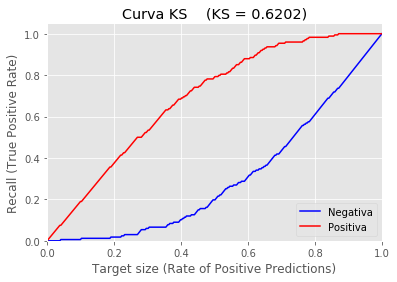

In [100]:
Grafico_KS(preds_rf_1[:,1],wine_test['Calidad'])

**Gráfico de Ganancia**

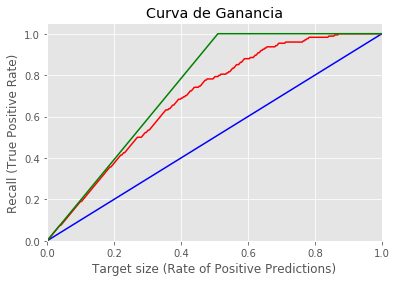

In [101]:
Grafico_Ganancia(preds_rf_1[:,1],wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



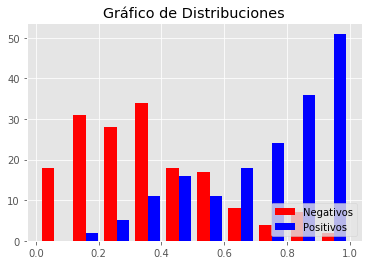

In [102]:
datosrf1 = pd.DataFrame({'Preds':preds_rf_1[:,1],'y':wine_test['Calidad']})
Grafico_Distribuciones(datosrf1)

**Curva ROC**

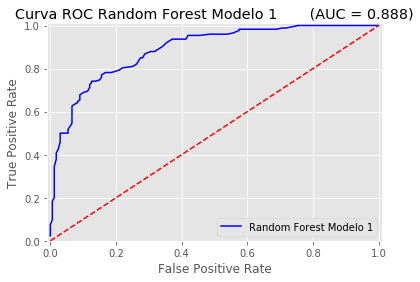

In [103]:
roc_rf_1 = metrics.roc_curve(wine_test['Calidad'], preds_rf_1[:,1])
Grafico_ROC(roc_rf_1, 'Random Forest Modelo 1')

**Modelo Variables Seleccionadas**

**Métricas**

In [104]:
Metricas_Modelo(wine_test['Calidad'], preds_rf_2[:,1], 0.5)

,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.815249,0.810056,0.833333,0.894091,0.134006,9.970674,8.504399


**Gráfico KS**

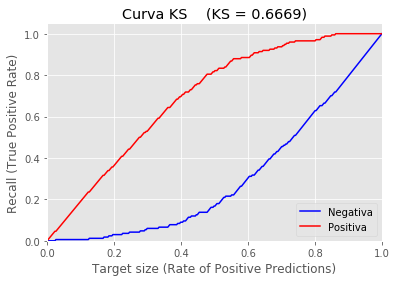

In [105]:
Grafico_KS(preds_rf_2[:,1],wine_test['Calidad'])

**Gráfico de Ganancia**

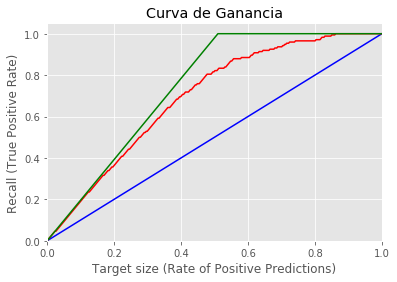

In [106]:
Grafico_Ganancia(preds_rf_2[:,1],wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



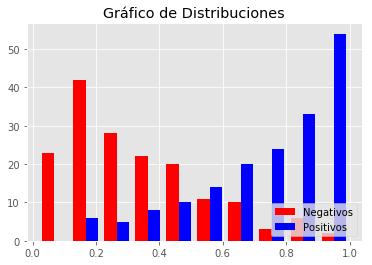

In [107]:
datosrf2 = pd.DataFrame({'Preds':preds_rf_2[:,1],'y':wine_test['Calidad']})
Grafico_Distribuciones(datosrf2)

**Curva ROC**

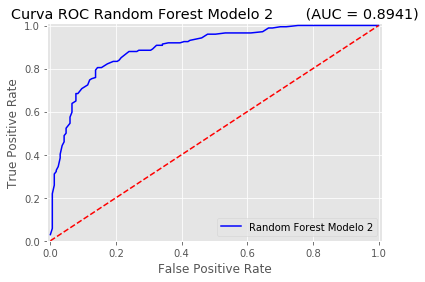

In [108]:
roc_rf_2 = metrics.roc_curve(wine_test['Calidad'], preds_rf_2[:,1])
Grafico_ROC(roc_rf_2, 'Random Forest Modelo 2')

### Logistic GAM

**Modelo Completo**

In [109]:
preds_gam_1 = fit_gam_1.predict_proba(Xte1)
roc_gam_1 = metrics.roc_curve(yte1, preds_gam_1)

**Métricas**

In [110]:
Metricas_Modelo(wine_test['Calidad'], preds_gam_1, 0.5)

,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.747801,0.768293,0.724138,0.81062,0.179628,11.143695,14.076246


**Gráfico KS**

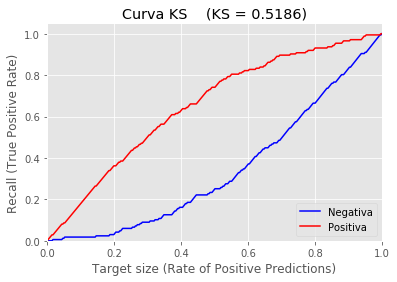

In [111]:
Grafico_KS(preds_gam_1,wine_test['Calidad'])

**Gráfico de Ganancia**

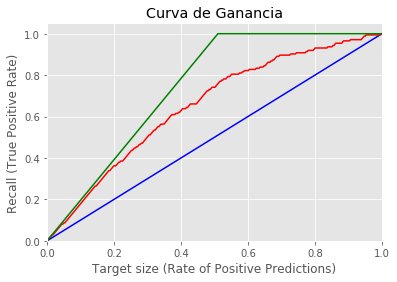

In [112]:
Grafico_Ganancia(preds_gam_1,wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



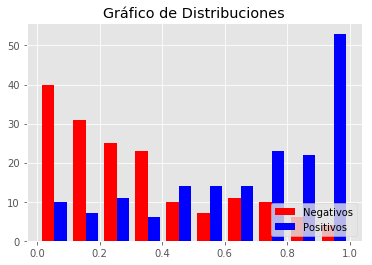

In [113]:
datosgam1 = pd.DataFrame({'Preds':preds_gam_1,'y':wine_test['Calidad']})
Grafico_Distribuciones(datosgam1)

**Curva ROC**

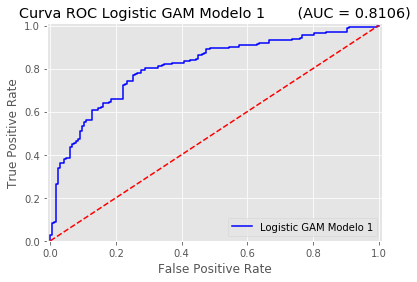

In [114]:
Grafico_ROC(roc_gam_1, 'Logistic GAM Modelo 1')

**Modelo Variables Seleccionadas**

In [115]:
preds_gam_2 = fit_gam_2.predict_proba(Xte2)
roc_gam_2 = metrics.roc_curve(yte2, preds_gam_2)

**Métricas**

In [116]:
Metricas_Modelo(wine_test['Calidad'], preds_gam_2, 0.5)

,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.739003,0.73743,0.758621,0.828687,0.168727,13.782991,12.316716


**Gráfico KS**

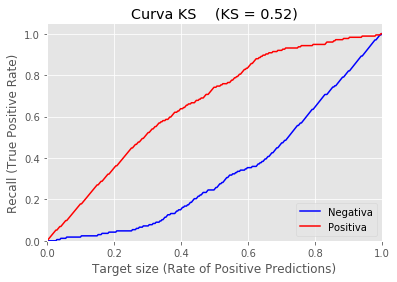

In [117]:
Grafico_KS(preds_gam_2,wine_test['Calidad'])

**Gráfico de Ganancia**

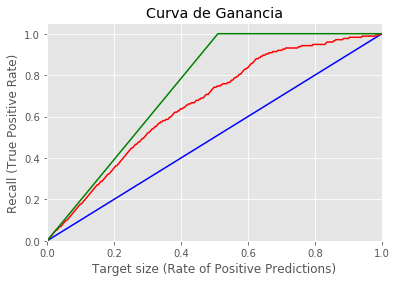

In [118]:
Grafico_Ganancia(preds_gam_2,wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



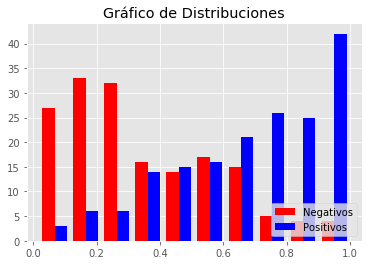

In [119]:
datosgam2 = pd.DataFrame({'Preds':preds_gam_2,'y':wine_test['Calidad']})
Grafico_Distribuciones(datosgam2)

**Curva ROC**

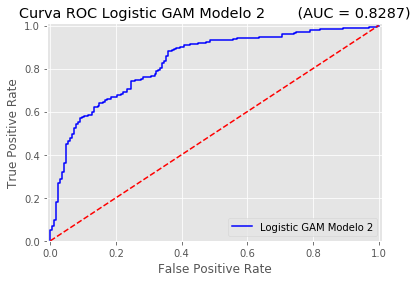

In [120]:
Grafico_ROC(roc_gam_2, 'Logistic GAM Modelo 2')

### Naive Bayes

In [121]:
roc_nb_1 = metrics.roc_curve(yte1, preds_nb_1[:, 1])

In [122]:
Metricas_Modelo(wine_test['Calidad'], preds_nb_1[:,1], 0.5)

,Punto de Corte,Accuracy,Precision,Recall,AUC,Brier,%fp,%fn
Valor,0.5,0.741935,0.798611,0.66092,0.820979,0.177655,8.504399,17.302053


**Gráfico KS**

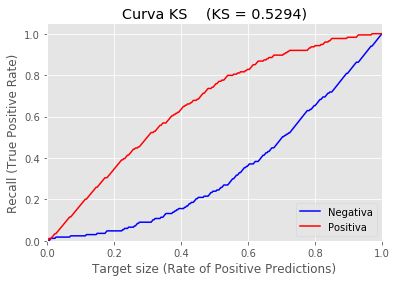

In [123]:
Grafico_KS(preds_nb_1[:,1],wine_test['Calidad'])

**Gráfico de Ganancia**

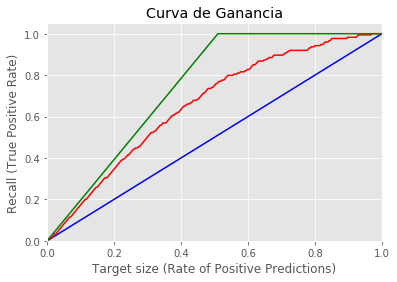

In [124]:
Grafico_Ganancia(preds_nb_1[:,1],wine_test['Calidad'])

**Gráfico de Distribuciones**

C:\Users\molih\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



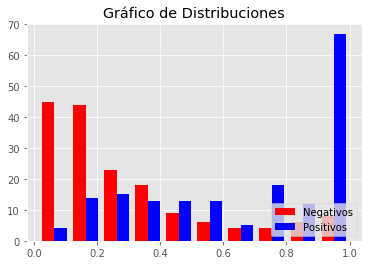

In [125]:
datosnaivebayes = pd.DataFrame({'Preds':preds_nb_1[:,1],'y':wine_test['Calidad']})
Grafico_Distribuciones(datosnaivebayes)

**Curva ROC**

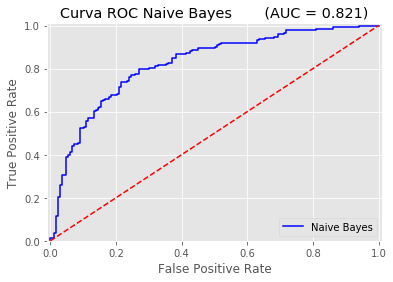

In [126]:
Grafico_ROC(roc_nb_1, 'Naive Bayes')

## Conclusiones

A partir del trabajo realizado, podemos decir que el modelo que mejor predice la calidad del vino tinto es el modelo Random Forest que considera las variables (en orden de importancia):  
- Alcohol
- Acidez Volátil
- Sulfatos
- Densidad
- Dióxido de azufre total
- Cloruros

Vimos que todos los modelos ajustados entregan buenas predicciones pero además, el modelo final escogido entrega las características químicas más influyentes e importantes al momento de determinar la calidad del vino, lo cual formaba parte de los objetivos principales. 

Con el trabajo realizado, es posible predecir de manera confiable si, dadas las características de cierto vino, este será considerado como de buena o mala calidad por los usuarios, facilitando la proyección de ventas y elección de precio de manera que se optimice la distribución del vino en cuestión. 

Además, el análisis entrega lineamientos para orientar la fabricación del vino y cuáles características considerar al momento de planificar la producción de un nuevo vino, para así lograr un vino de óptima calidad. 